<a href="https://colab.research.google.com/github/davidsjohnson/blockies-xai/blob/main/blockies_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

from PIL import Image

torch.backends.cudnn.benchmark = True

In [ ]:
torch.__version__

'2.5.1+cu121'

# Params

In [ ]:
CLASSES = ['Healthy', 'OC Degeneration']

load_checkpoints = True

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

# Setup and Load Datasets

In [ ]:
relative_model_path = "two4two_sickones_models_pytorch"
base_path = Path('/content/drive/MyDrive') / relative_model_path
base_path

PosixPath('/content/drive/MyDrive/two4two_sickones_models_pytorch')

In [ ]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif archive_folder is not None and (Path(cache_dir) / archive_folder).exsists:
      return Path(cache_dir) / archive_folder
    else:
      return Path(cache_dir)

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)

  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [ ]:
# download datafrom sciebo
data_dir = download_file("https://uni-bielefeld.sciebo.de/s/2BgY19ixIaEUOmS/download",
                         "two4two_datasets.tar.gz",
                         cache_dir='/content/data',
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

100%|██████████| 4.67G/4.67G [04:20<00:00, 19.2MB/s]


File downloaded to: /content/data/two4two_datasets.tar.gz
File extracted to: /content/data


PosixPath('/content/data/two4two_datasets')

In [ ]:
ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

(PosixPath('/content/data/two4two_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('/content/data/two4two_datasets/sick_ones_bendbias_v3_2class_variation'))

In [ ]:
train_df = load_dataframe(ds_dir, 'train')
train_transforms = T.Compose([
    T.ToTensor()
])
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=train_transforms)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True,
                        num_workers=6, pin_memory=True)

# Initialize variables to calculate mean
mean = torch.zeros(3)  # For RGB channels
total_pixels = 0

# Loop through the dataset
for images, _ in tqdm(dataloader):
    # Sum pixel values per channel
    mean += images.sum(dim=[0, 2, 3])
    total_pixels += images.size(0) * images.size(2) * images.size(3)

# Divide by total number of pixels
mean /= total_pixels

print(f"Mean per channel: {mean}")

# Initialize variables for std calculation
std = torch.zeros(3)

# Loop again for standard deviation
for images, _ in tqdm(dataloader):
    std += ((images - mean.view(1, 3, 1, 1))**2).sum(dim=[0, 2, 3])

std = torch.sqrt(std / total_pixels)

print(f"Standard Deviation per channel: {std}")

100%|██████████| 400/400 [00:14<00:00, 27.83it/s]


Mean per channel: tensor([0.8068, 0.7830, 0.8005])


100%|██████████| 400/400 [00:14<00:00, 28.55it/s]

Standard Deviation per channel: tensor([0.1093, 0.1136, 0.1029])


In [ ]:
# Comprehensive Data Augmentation Pipeline
transform_train = T.Compose([
    # Resize and Crop
    T.RandomResizedCrop(128, scale=(0.8, 1.0)),
    # Flipping
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.1),
    # Rotation
    T.RandomRotation(degrees=30),
    # Affine Transformations
    T.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ),
    # Perspective Transformation
    T.RandomPerspective(distortion_scale=0.5, p=0.5),
    # Color Augmentations
    T.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.1
    ),
    # Grayscale
    T.RandomGrayscale(p=0.1),
    # Blur
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    T.ToTensor(),
    # Random Erasing
    T.RandomErasing(
        p=0.5,
        scale=(0.02, 0.33),
        ratio=(0.3, 3.3)
    ),
    T.Normalize(mean=mean, std=std)
])

# load datasets and dataloaders for Training and Evaluation
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [ ]:
train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

# # downsample val and test for for balanced classes
# min_val = val_df['ill'].value_counts().min()
# min_test = test_df['ill'].value_counts().min()
# min_eval = eval_df['ill'].value_counts().min()

# val_df = val_df.groupby('ill').apply(lambda x: x.sample(min_val)).reset_index(drop=True)
# test_df = test_df.groupby('ill').apply(lambda x: x.sample(min_test)).reset_index(drop=True)
# eval_df = eval_df.groupby('ill')za`.apply(lambda x: x.sample(min_eval)).reset_index(drop=True)

In [ ]:
len(val_df), len(test_df), len(eval_df), len(train_df)

(1000, 3000, 3000, 40000)

In [ ]:
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

train_eval_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_eval_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False,
                                   num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

In [ ]:
data_ex = next(iter(train_dataloader))
data_ex[0].shape, data_ex[1].shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

# Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis Dataset

In [ ]:
# create column for absolute sphere difference
train_df['sphere_diff'] = np.abs(train_df['spherical'] - train_df['ill_spherical'])
val_df['sphere_diff'] = np.abs(val_df['spherical'] - val_df['ill_spherical'])
test_df['sphere_diff'] = np.abs(test_df['spherical'] - test_df['ill_spherical'])
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])

### Training Data


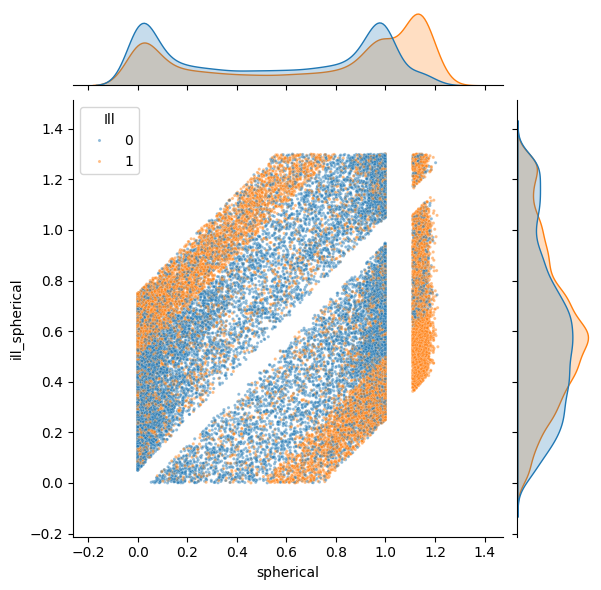

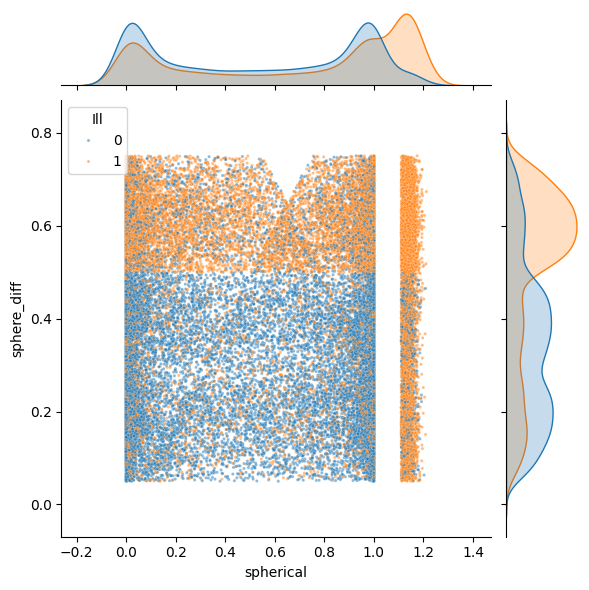

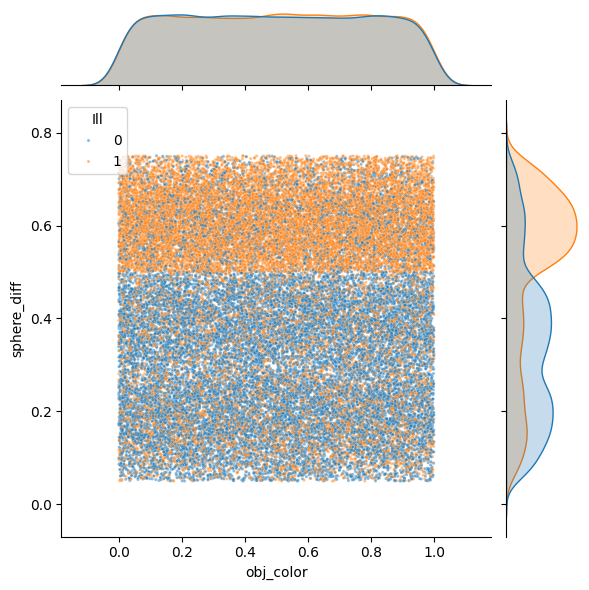

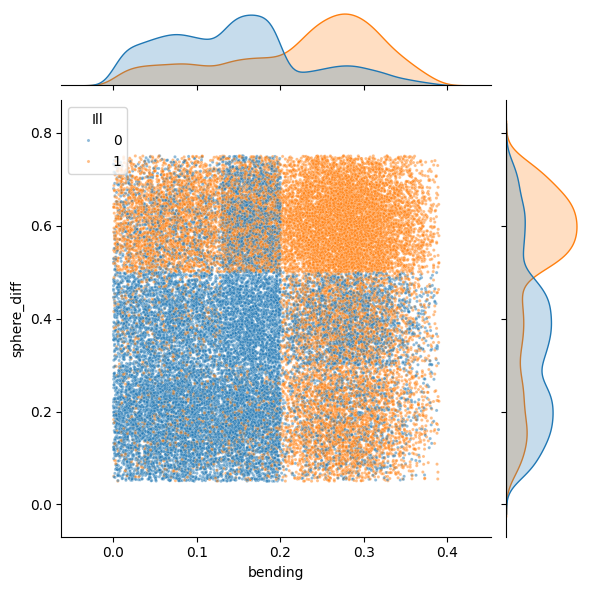

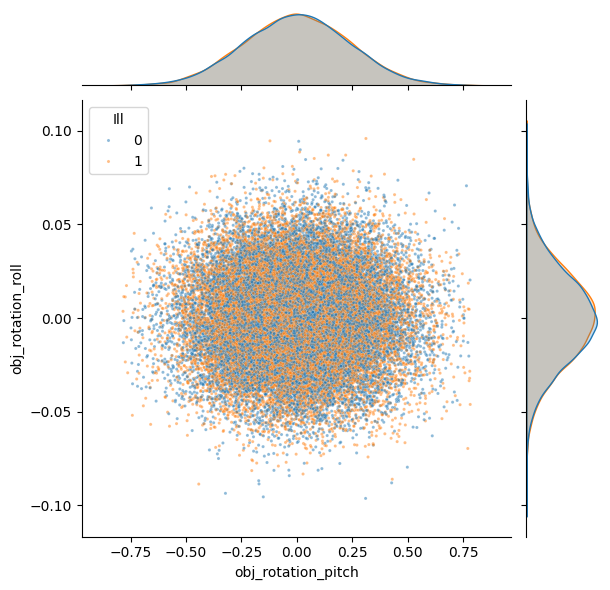

In [ ]:
g =sns.jointplot(data=train_df, x='spherical', y='ill_spherical', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g =sns.jointplot(data=train_df, x='spherical', y='sphere_diff', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=train_df, x='obj_color', y='sphere_diff', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=train_df, x='bending', y='sphere_diff', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=train_df, x='obj_rotation_pitch', y='obj_rotation_roll', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

### Test Data

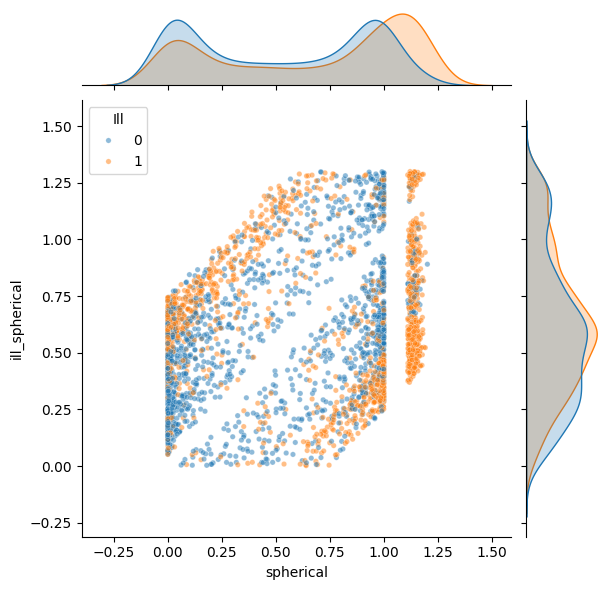

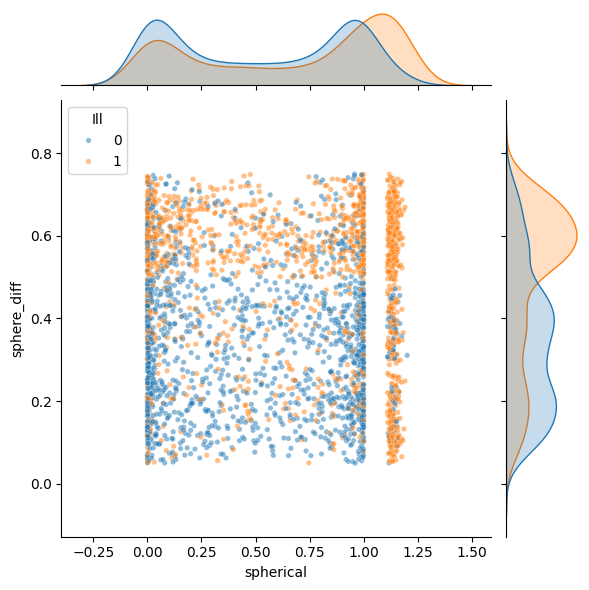

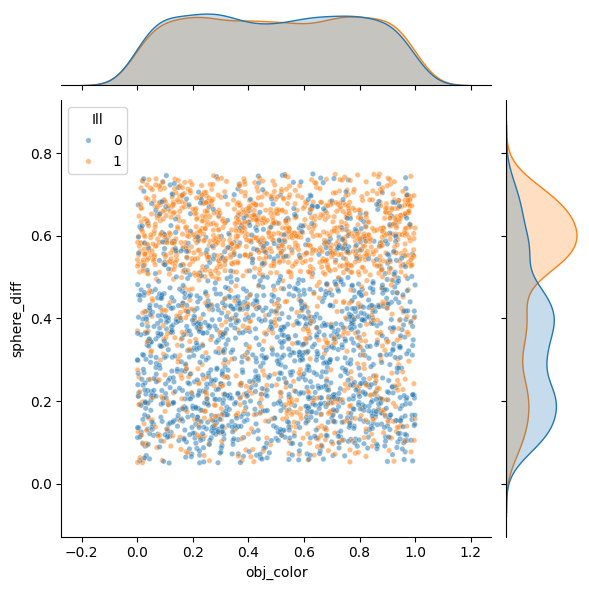

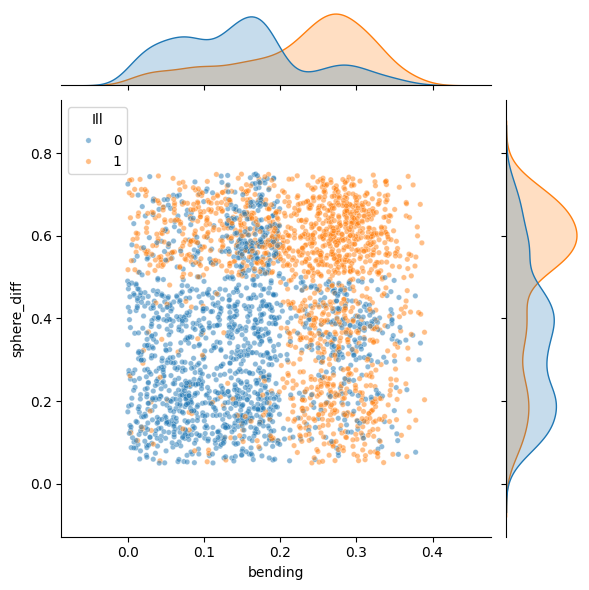

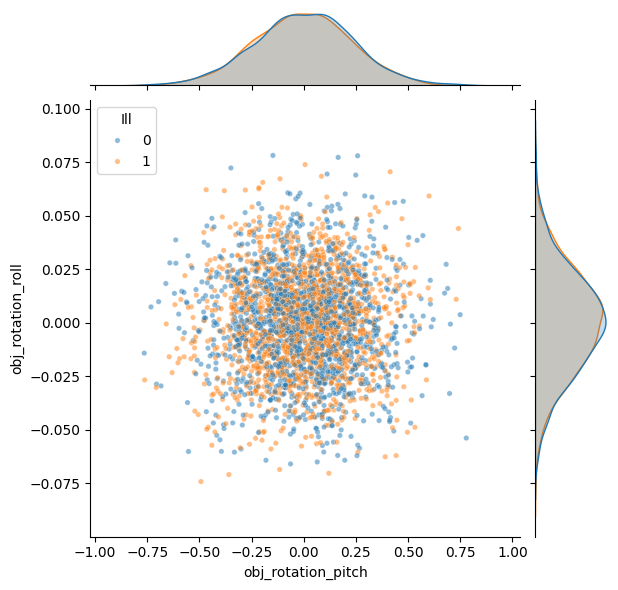

In [ ]:
g =sns.jointplot(data=test_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g =sns.jointplot(data=test_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=test_df, x='obj_color', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=test_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=test_df, x='obj_rotation_pitch', y='obj_rotation_roll', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

### Eval Data

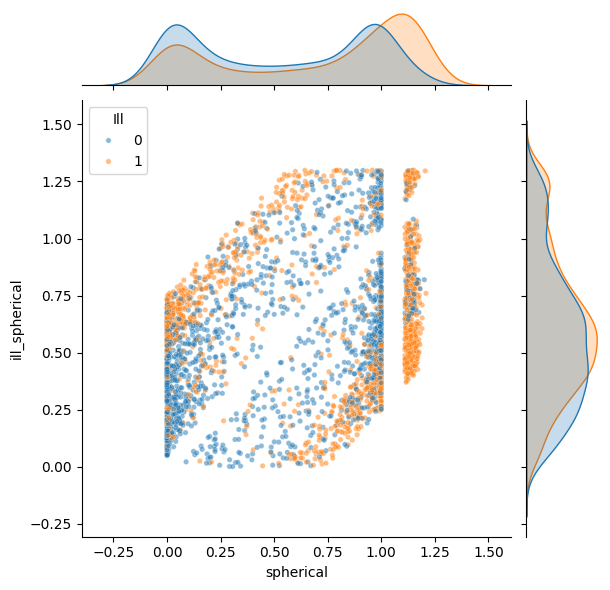

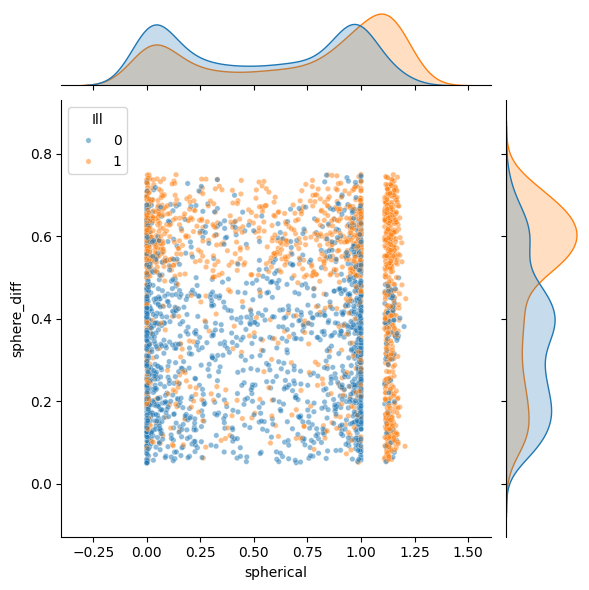

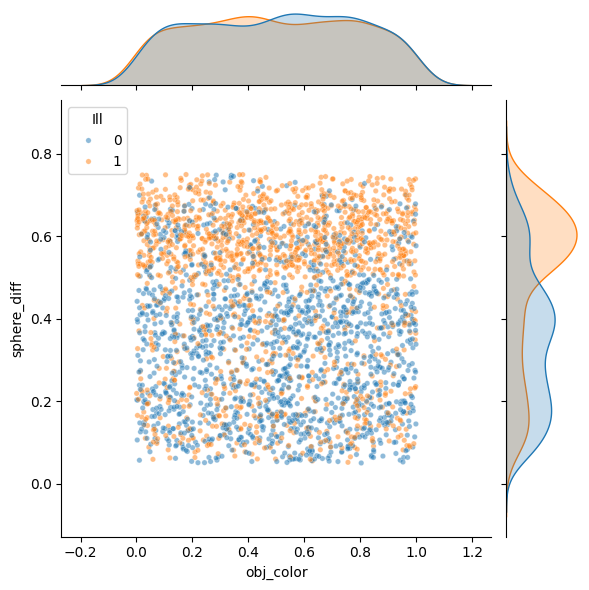

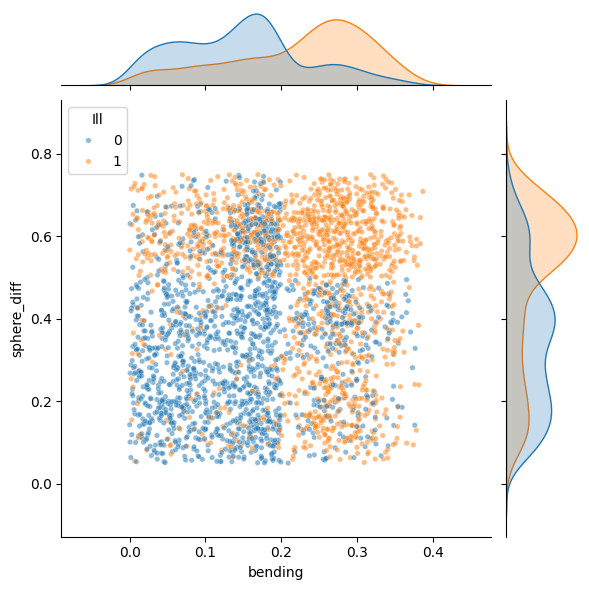

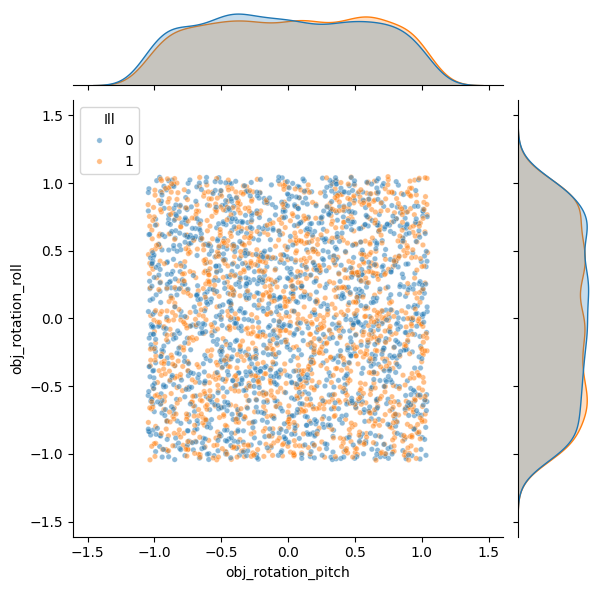

In [ ]:
g = sns.jointplot(data=eval_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=eval_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=eval_df, x='obj_color', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=eval_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=eval_df, x='obj_rotation_pitch', y='obj_rotation_roll', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

# Model Training and Evaluation

In [ ]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [ ]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return np.array(preds), avg_loss, accuracy

def train_model(model, dl_train, dl_val, criterion, optimizer, scheduler, device, checkpoint_path, num_epochs=10):

  model = model.to(device)

  best_val_loss = sys.float_info.max
  best_epoch = 0

  for epoch in range(num_epochs):

    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # Training phase
    model.train()

    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dl_train:
        # print(inputs.shape, labels.shape, inputs.min(), inputs.max(), inputs.mean())
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(dl_train)
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in dl_val:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(dl_val)
    val_accuracy = correct_val / total_val

    scheduler.step(val_loss)

    # Print epoch results
    print(f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"\tValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Checkpointing the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"New best model found at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        best_epoch = epoch + 1
        torch.save(model.state_dict(), checkpoint_path / 'tmp' / 'best_model.pth')  # Save only the model's state_dict

  # To load the best model later:
  model = load_mobilenetv2(num_classes=len(CLASSES),
                           pretrained=False,
                           checkpoint_path=checkpoint_path / 'tmp' / 'best_model.pth')
  model.to(device)

  _, val_loss, val_acc = evaluate_model(model, dl_val, criterion, device)

  print(f"Training Run complete! Val loss = {best_val_loss:.4f} | Val acc = {val_acc:.4f} | Epoch = {best_epoch}", )
  print("-" * 30)

  return model, val_loss, val_acc



## Train Model

In [ ]:
# setup model path
model_path = base_path / ds / f'{modeltype}'
model_path.mkdir(parents=True, exist_ok=True)
print("Model path:", model_path)

# setup checkpoint folders
checkpoint_path = model_path / "torch_mobilenetv2/"
(checkpoint_path / 'tmp').mkdir(parents=True, exist_ok=True)
(checkpoint_path / 'final').mkdir(parents=True, exist_ok=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Model path: /content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet


device(type='cuda')

In [ ]:
# run training
n_runs = 1
n_epochs = 50

load_checkpoints = False
learning_rate = 0.001

best_val_loss = sys.float_info.max
for i in range(n_runs):

  set_seed(42 + i)

  print(f"Run {i+1} / {n_runs}")
  print("=" * 30)

  if i > 0:
    print('loading previous checkpoint with augmentation')
    load_checkpoints = True

  if i >= 0:
    # load previous checkpoint and train without augmentation
    print('Loading previous checkpoint and training with out augmentation')
    train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                                  num_workers=6, pin_memory=True)


  model = load_mobilenetv2(len(CLASSES), pretrained=False, checkpoint_path= checkpoint_path / 'final' / 'best_model.pth' if load_checkpoints else None)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)

  # Scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=4,
                                                          threshold=0.01, threshold_mode='abs')

  model, val_loss, val_acc = train_model(model,
                                         train_dataloader, val_dataloader,
                                         criterion, optimizer, scheduler,
                                         device, checkpoint_path,
                                         num_epochs=n_epochs)

  # Checkpointing the best model
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      print(f"New best model found at Run {i+1} with validation loss: {val_loss:.4f}")
      torch.save(model.state_dict(), checkpoint_path / 'final' / 'best_model.pth')  # Save only the model's state_dict
  print()

# Load best model:
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device)

_, val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

print(f"Training complete! Val loss = {best_val_loss:.4f} | Val acc = {val_acc:.4f}", )
print("-" * 30)

Run 1 / 1
Loading previous checkpoint and training with out augmentation
Epoch [1/50]
	Train Loss: 0.6424, Train Accuracy: 0.6261
	Validation Loss: 0.5766, Validation Accuracy: 0.7060
New best model found at epoch 1 with validation loss: 0.5766
Epoch [2/50]
	Train Loss: 0.5391, Train Accuracy: 0.7270
	Validation Loss: 0.5521, Validation Accuracy: 0.7210
New best model found at epoch 2 with validation loss: 0.5521
Epoch [3/50]
	Train Loss: 0.5013, Train Accuracy: 0.7534
	Validation Loss: 0.5102, Validation Accuracy: 0.7480
New best model found at epoch 3 with validation loss: 0.5102
Epoch [4/50]
	Train Loss: 0.4667, Train Accuracy: 0.7765
	Validation Loss: 0.4834, Validation Accuracy: 0.7560
New best model found at epoch 4 with validation loss: 0.4834
Epoch [5/50]
	Train Loss: 0.4420, Train Accuracy: 0.7898
	Validation Loss: 0.4932, Validation Accuracy: 0.7870
Epoch [6/50]
	Train Loss: 0.4243, Train Accuracy: 0.7996
	Validation Loss: 0.4348, Validation Accuracy: 0.8010
New best model fo

<ipython-input-19-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Evaluation Loss: 0.2100, Evaluation Accuracy: 0.9140
Training Run complete! Val loss = 0.2100 | Val acc = 0.9140 | Epoch = 35
------------------------------
New best model found at Run 1 with validation loss: 0.2100

Loaded checkpoint from: /content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_mobilenetv2/final/best_model.pth
Evaluation Loss: 0.2100, Evaluation Accuracy: 0.9140
Training complete! Val loss = 0.2100 | Val acc = 0.9140
------------------------------


## Evaluate Model

In [ ]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device)

train_preds, _, _ = evaluate_model(model, train_eval_dataloader, criterion, device)
evaluate_model(model, val_dataloader, criterion, device)
test_preds, _, _ = evaluate_model(model, test_dataloader, criterion, device)
eval_preds, _, _ = evaluate_model(model, eval_dataloader, criterion, device)

Loaded checkpoint from: /content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_mobilenetv2/final/best_model.pth


<ipython-input-19-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Evaluation Loss: 1.6836, Evaluation Accuracy: 0.5348
Evaluation Loss: 0.2100, Evaluation Accuracy: 0.9140
Evaluation Loss: 0.2288, Evaluation Accuracy: 0.9043
Evaluation Loss: 0.9181, Evaluation Accuracy: 0.6937


In [ ]:
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device);

Loaded checkpoint from: /content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_mobilenetv2/final/best_model.pth


<ipython-input-19-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
debug_dataset = ImageDataset(train_df.sample(10000), ds_dir / 'train', transform=transform)
debug_dataloader = DataLoader(debug_dataset, batch_size=32, shuffle=False,
                              num_workers=6, pin_memory=True)

In [ ]:
evaluate_model(model, debug_dataloader, criterion, device);

Evaluation Loss: 0.0935, Evaluation Accuracy: 0.9663


In [ ]:
train_df['pred'] = train_preds
test_df['pred'] = test_preds
eval_df['pred'] = eval_preds

test_df.to_csv(model_path / 'test_preds.csv', index=False)
eval_df.to_csv(model_path / 'eval_preds.csv', index=False)

In [ ]:
train_correct = (train_df['pred'] == train_df['ill'].astype(int))
test_correct = (test_df['pred'] == test_df['ill'].astype(int))
eval_correct = (eval_df['pred'] == eval_df['ill'].astype(int))

In [ ]:
eval_correct.astype(int).mean(), test_correct.astype(int).mean(), train_correct.astype(int).mean()

(0.6936666666666667, 0.9043333333333333, 0.5348)

### Test Accuracy

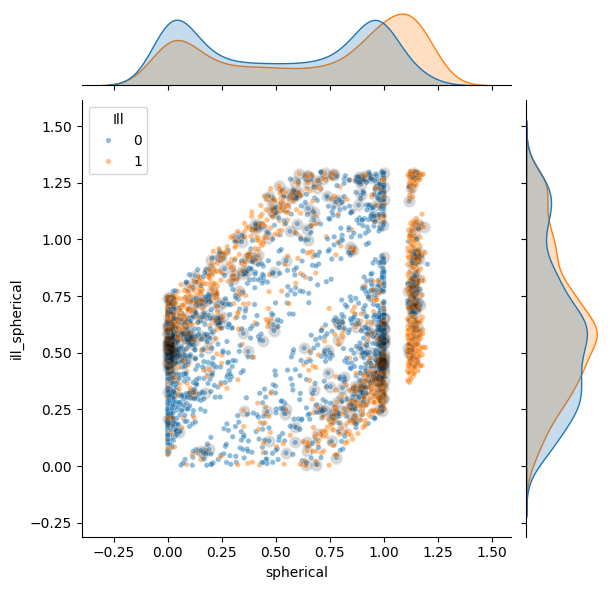

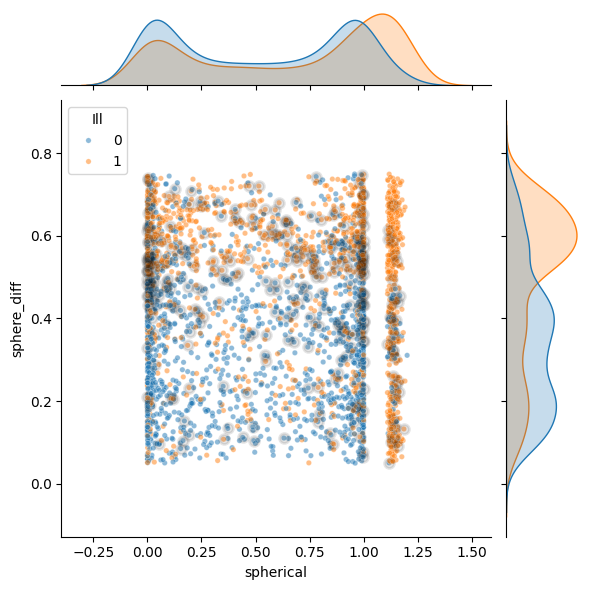

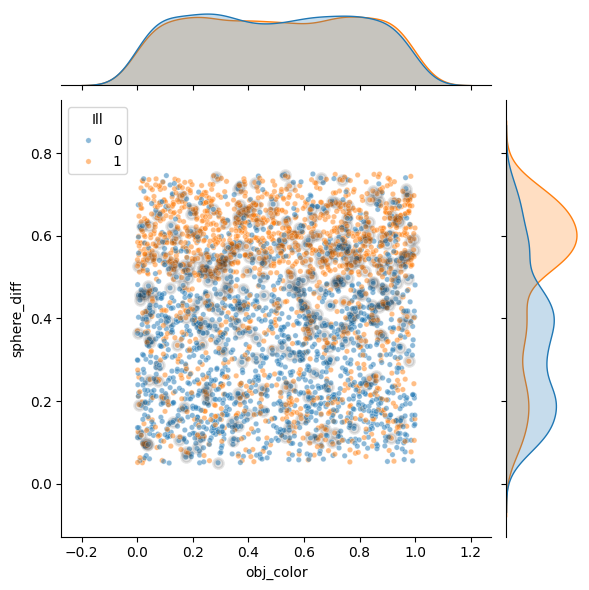

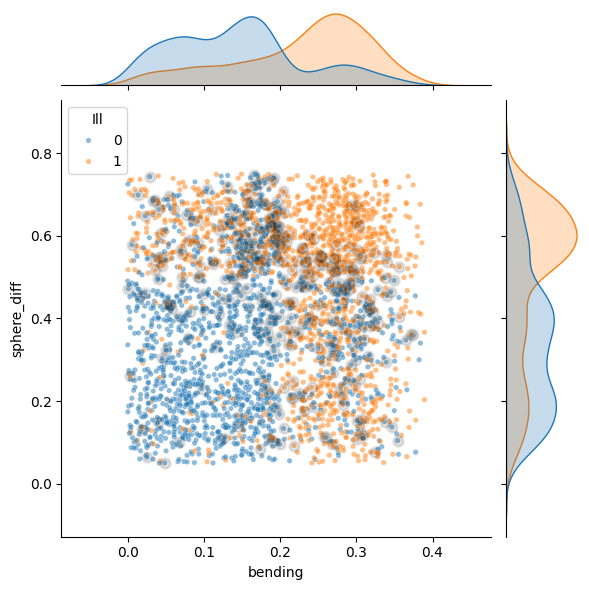

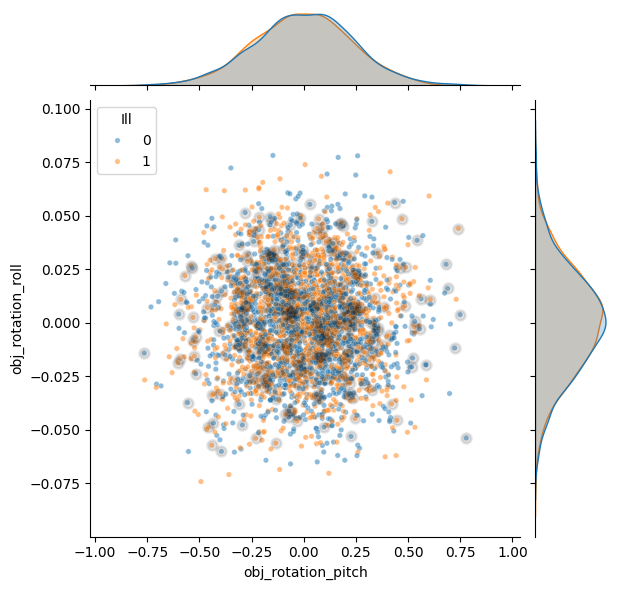

In [ ]:
g = sns.jointplot(data=test_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(test_df[~test_correct]['spherical'], test_df[~test_correct]['ill_spherical'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=test_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(test_df[~test_correct]['spherical'], test_df[~test_correct]['sphere_diff'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=test_df, x='obj_color', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(test_df[~test_correct]['obj_color'], test_df[~test_correct]['sphere_diff'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=test_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(test_df[~test_correct]['bending'], test_df[~test_correct]['sphere_diff'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=test_df, x='obj_rotation_pitch', y='obj_rotation_roll', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(test_df[~test_correct]['obj_rotation_pitch'], test_df[~test_correct]['obj_rotation_roll'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

### Eval Accuracy

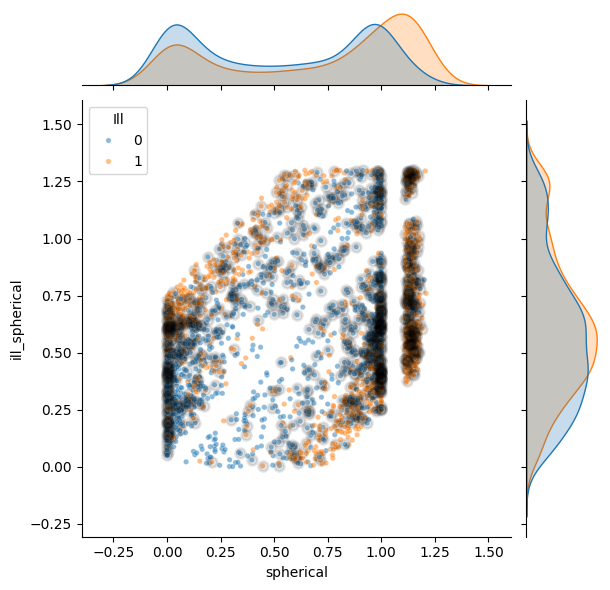

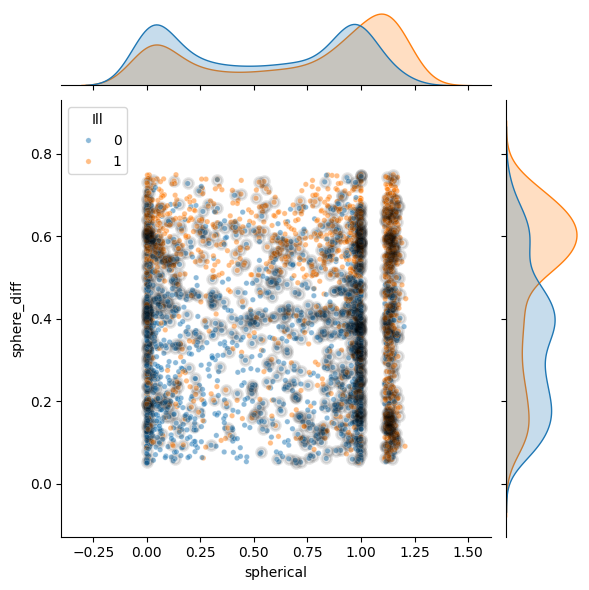

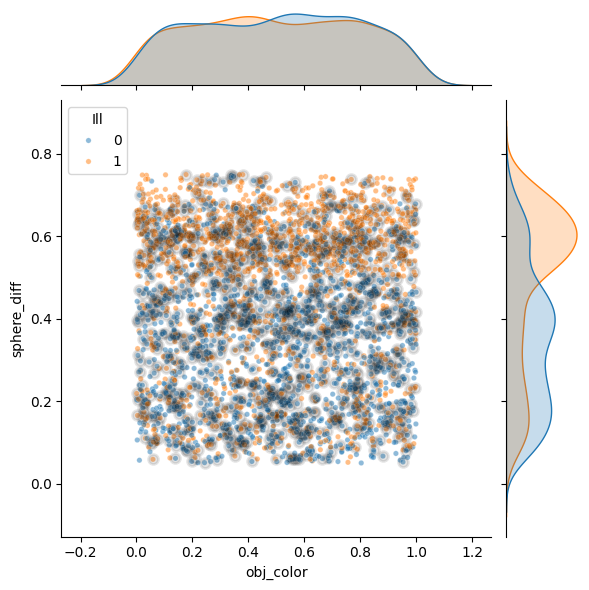

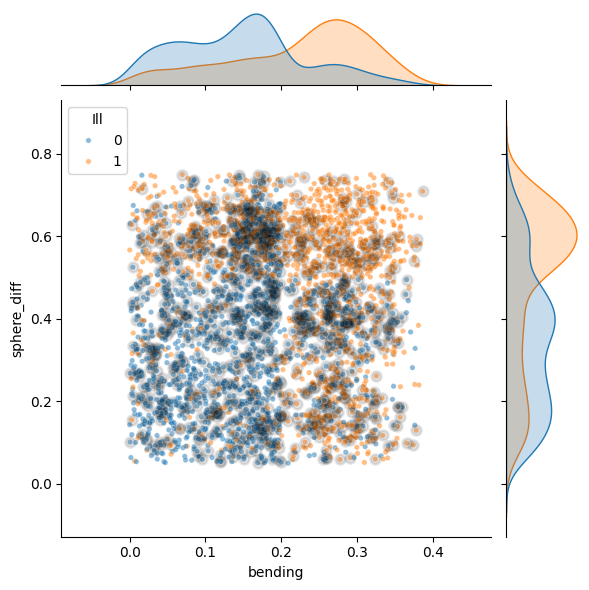

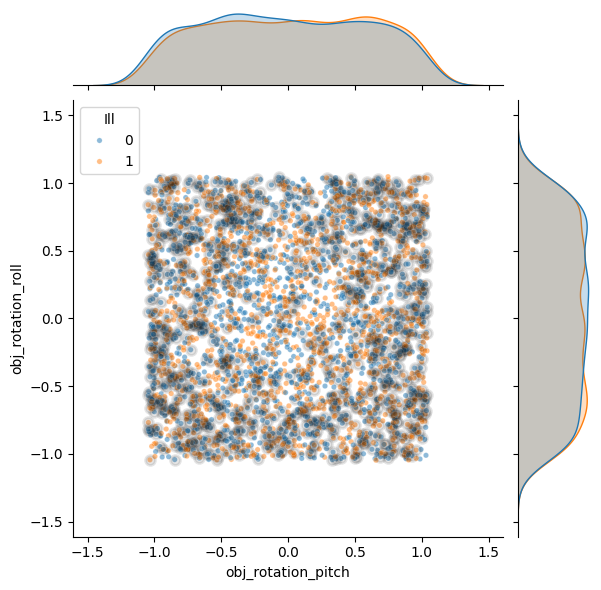

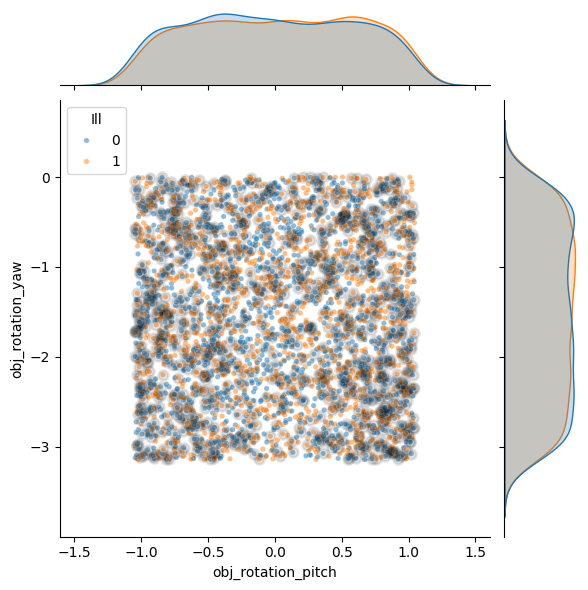

In [ ]:
g = sns.jointplot(data=eval_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(eval_df[~eval_correct]['spherical'], eval_df[~eval_correct]['ill_spherical'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(eval_df[~eval_correct]['spherical'], eval_df[~eval_correct]['sphere_diff'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='obj_color', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(eval_df[~eval_correct]['obj_color'], eval_df[~eval_correct]['sphere_diff'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(eval_df[~eval_correct]['bending'], eval_df[~eval_correct]['sphere_diff'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='obj_rotation_pitch', y='obj_rotation_roll', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(eval_df[~eval_correct]['obj_rotation_pitch'], eval_df[~eval_correct]['obj_rotation_roll'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='obj_rotation_pitch', y='obj_rotation_yaw', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(eval_df[~eval_correct]['obj_rotation_pitch'], eval_df[~eval_correct]['obj_rotation_yaw'], color='black', alpha=0.1, s=50, zorder=1, linewidth=2)